# 3_points

## Importar bibliotecas

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import networkx as nx

## Leer imagen en escala de grises

Leer la imagen, esta imagen ya debe de tener bien definidos los bordes, de preferencia deberá de ser una imagen binaria con el fondo de color negro y las líneas deberán de ser de color blanco.

In [2]:
#path = "/home/uli/Pictures/LainViernesbin_cropskeleton.jpg" # single image
path = "lainGIF/edge/*.jpg" # folder with pattern

files = sorted(glob.glob(path))

show_all_frames = False

if os.path.isfile(path): # for a single static image
    print("Is file")
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    print("Image size: ", image.shape)
elif os.path.isdir(path):
    print("Is directory")
else:
    # If your set of images is .jpg erase the bin.jpg or edge.jpg images if there is any.
    print("Is folder with pattern") # folder with pattern
    [print(file) for file in files]
    images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in files]
    
    print("images list size: ", len(images))
    print("Image size: ", images[0].shape)

Is folder with pattern
lainGIF/edge/frame5.jpg
lainGIF/edge/frame1.jpg
lainGIF/edge/frame7.jpg
lainGIF/edge/frame0.jpg
lainGIF/edge/frame3.jpg
lainGIF/edge/frame6.jpg
lainGIF/edge/frame4.jpg
lainGIF/edge/frame2.jpg
images list size:  8
Image size:  (326, 367, 3)


## Binarizar la imagen

Idealmente las imágenes que entran a este `notebook` deberian de ya estar binarizadas pero en el caso de que hayan sido modificadas en algún software de edición de image como `GIMP` y quedaran algunos pixeles grises el algoritmo de Otsu se encargaría de binarizarlos.

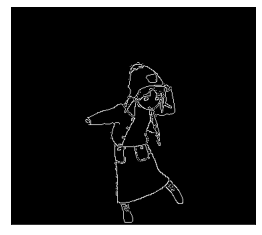

In [3]:
if len(files) == 1:
    ret, bin_image = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plt.imshow(bin_image,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
else:
    bin_images = [cv2.threshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] for image in images]
    if show_all_frames:
        for image in bin_images:
            plt.figure()
            plt.imshow(image,cmap="gray")
            plt.xticks([]), plt.yticks([])
    else:
        plt.imshow(bin_images[0],cmap="gray")
        plt.xticks([]), plt.yticks([])

Graficar las imágenes de entrada y de salida.

Podemos notar que hay una menor cantidad de pixeles blancos por lo que requeriremos de menor tiempo para graficar la imagen.

Además no se pierde la forma del diseño de la imagen.

## Extraer los pixeles que pertenecen al borde

In [4]:
def borderPixels(bin_image):
    x = np.empty([0, 1], dtype=np.int16)
    y = np.empty([0, 1], dtype=np.int16)

    # La forma en la que pasamos los pixeless de la imagen a un arreglo hace que la imagen salga rotada 
    # así que antes de obtener las coordenadas rotamos la imagen al lado contrario.
    rotated = cv2.rotate(bin_image, cv2.cv2.ROTATE_90_CLOCKWISE)

    for index,line in enumerate(rotated):
        for jndex,pixel in enumerate(line):
            if pixel != 0:
                x = np.append(x, index)
                y = np.append(y, jndex)
    return [x, y]

In [5]:
if len(files) == 1:
    border_pixels = borderPixels(bin_image)
    print("Se encontraron", len(border_pixels[0]), "puntos")
    print(border_pixels[0])
    print(border_pixels[1])
else:
    borders_pixels = [borderPixels(bin_im) for bin_im in bin_images]
    frame_size = []
    for i,border_pixels in enumerate(borders_pixels):
        print("El frame", i, "tiene", len(border_pixels[0]), "puntos")
        frame_size.append(len(border_pixels[0]))

El frame 0 tiene 1997 puntos
El frame 1 tiene 1980 puntos
El frame 2 tiene 2023 puntos
El frame 3 tiene 2121 puntos
El frame 4 tiene 2127 puntos
El frame 5 tiene 2101 puntos
El frame 6 tiene 2054 puntos
El frame 7 tiene 2082 puntos


## Graficar las coordenadas del borde

### Graficar puntos

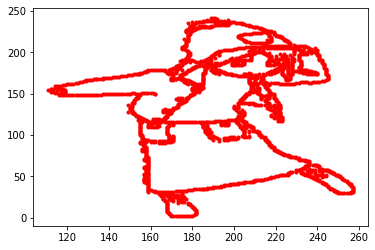

In [6]:
if len(files) == 1:
    plt.scatter(border_pixels[0], border_pixels[1], color = "red", marker = ".", label = "Array elements")
else:
    if show_all_frames:
        for frame in borders_pixels:
            plt.figure()
            plt.scatter(frame[0], frame[1], color = "red", marker = ".")
    else:
        plt.scatter(borders_pixels[0][0], borders_pixels[0][1], color = "red", marker = ".")

### Graficar líneas

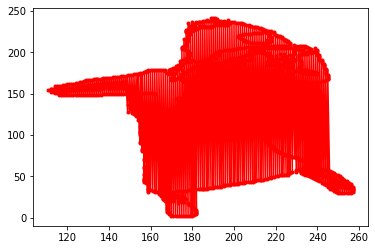

In [7]:
if len(files) == 1:
    plt.plot(border_pixels[0], border_pixels[1], color = "red", marker = ".", label = "Array elements")
else:
    if show_all_frames:
        for frame in borders_pixels:
            plt.figure()
            plt.plot(frame[0], frame[1], color = "red", marker = ".")
    else:
        plt.plot(borders_pixels[0][0], borders_pixels[0][1], color = "red", marker = ".")

De lo anterior podemos notar que los puntos no están ordenados de lo contrario al graficar los datos anteriores con líneas observariamos que las líneas seguirían un camino alrededor del borde.

## Ordenamiento de los puntos

Ahora vamos a ordenar los puntos de forma que se minimice la distancia recorrida del punto.

En principio este paso no es necesario pero solo si el osciloscopio que usas muestra las líneas entre dos puntos (esas que se ven en la gráfica anterior pero no en la anterior a la anterior XD).

Es evidente que tenemos que resolver un `problema de minimización` de distancia ([referencia](https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line?answertab=votes#tab-top)), resolver este problema usando fuerza bruta sería muy costoso computacionalmente hablando ya que es NP-hard y tiene un tiempo de resolución de $O(n!)$ así que para imágenes con muchos puntos es preferible usar otros algoritmos.

In [8]:
def orderedPoints(border, n, r):
    
    points = np.c_[border[0], border[1]]
    
    clf = NearestNeighbors(n_neighbors=n, radius=r).fit(points)
    G = clf.kneighbors_graph()
    #print(type(G))

    T = nx.from_scipy_sparse_matrix(G)
    #print(type(T))

    # So many points -> ugly graph
    #nx.draw(T)

    order = list(nx.dfs_preorder_nodes(T, 0))
    #print(type(order))
    xx = border[0][order]
    yy = border[1][order]
    
    return [xx, yy]

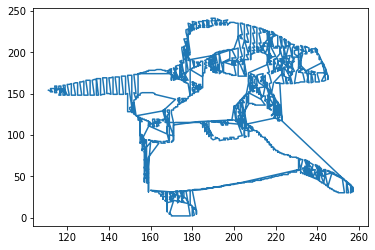

In [9]:
if len(files) == 1:
    ordered_border_px = orderedPoints(border_pixels, 90, 100)
    plt.plot(ordered_border_px[0], ordered_border_px[1])
else:
    ordered_borders_px = [orderedPoints(border_pixels, 90, 100) for border_pixels in borders_pixels]
    if show_all_frames:
        for frame in ordered_borders_px:
            plt.figure()
            plt.plot(frame[0], frame[1])
    else:
        plt.plot(ordered_borders_px[0][0], ordered_borders_px[0][1])

## Normalizar los valores

[2, 2, 2, 2, 2, 1, 2, 2]
min val: 1
max val: 257


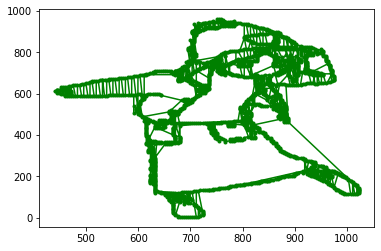

In [10]:
k = 1023  # Amplitud value of the signals, could be the resolution, ej: 10 bits -> 1023, 12 bits -> 4095, etc

if len(files) == 1:
    print(len(ordered_border_px))
    print(len(ordered_border_px[0]))
    minVal = np.amin(ordered_border_px)
    print("min val:", minVal)
    maxVal = np.amax(ordered_border_px)
    print("max val:", maxVal)
    
    ordered_border_px = k * ((ordered_border_px - minVal) / ( maxVal - minVal))
    
    plt.scatter(ordered_border_px[0], ordered_border_px[1], color = "green", marker = ".")
else:
    minVal = [np.amin(ordered_border_px) for ordered_border_px in ordered_borders_px]
    print(minVal)
    minVal2 = np.amin(minVal)
    print("min val:", minVal2)
    maxVal = [np.amax(ordered_border_px) for ordered_border_px in ordered_borders_px]
    maxVal2 = np.amax(maxVal)
    print("max val:", maxVal2)
    
    scaled_data = []
    for frame in ordered_borders_px:
        scaled_data.append(k * ((frame - minVal2) / ( maxVal2 - minVal2)))
    
    if show_all_frames:
        for frame in scaled_data:
            plt.figure()
            plt.plot(frame[0], frame[1], color = "green", marker = ".")
    else:
        plt.plot(scaled_data[0][0], scaled_data[0][1], color = "green", marker='.')

## Creating an Arduino library

In [11]:
if len(files) == 1:
    print("Saving: data"+os.path.splitext(os.path.basename(path))[0]+".h")
    with open("data"+os.path.splitext(os.path.basename(path))[0]+".h", 'w') as f:
        f.write("#ifndef data\n")
        f.write("#define data\n\n")
        f.write("#define DATA_LENGTH ")
        f.write('%d' % len(np.transpose(ordered_border_px)))
        f.write("\n")
        f.write("#define X 0\n")
        f.write("#define Y 1\n\n")
        f.write("const int pointData[")
        f.write('%d' % len(np.transpose(ordered_border_px)))
        f.write("][2] = {\n")
        for i,data in enumerate(np.transpose(ordered_border_px)):
            f.write("\t{")
            f.write('%4d' % data[0])
            f.write(", ")
            f.write('%4d' % data[1])
            if i < len(np.transpose(ordered_border_px))-1:
                f.write("},\n")
            else:
                f.write("}\n")
        f.write("};\n\n#endif\n")
        f.close()
else:
    print("Saving: data"+path.split(os.sep)[0]+".h")
    with open("data"+path.split(os.sep)[0]+".h", 'w') as f:
        f.write("#ifndef data\n")
        f.write("#define data\n\n")
        f.write("#define FRAMES ")
        f.write('%d' % len(files))
        f.write("\n")
        f.write("#define DATA_LENGTH ")
        f.write('%d' % np.amax(frame_size))
        f.write("\n")
        f.write("#define X 0\n")
        f.write("#define Y 1\n\n")
        f.write("const int frameSize[")
        f.write('%d' % len(frame_size))
        f.write("] = {")
        for k,size in enumerate(frame_size):
            f.write('%d' % size)
            if k < len(frame_size)-1:
                f.write(", ")
        f.write("};\n\n")
        f.write("const int pointData[")
        f.write('%d' % len(files))
        f.write("][")
        f.write('%d' % np.amax(frame_size))
        f.write("][2] = {\n")
        for i,ordered_border_px in enumerate(scaled_data):
            f.write("\t{\n")
            for ii,data in enumerate(np.transpose(ordered_border_px)):
                f.write("\t\t{")
                for iii,x in enumerate(data):
                    f.write('%4d' % x)
                    if iii == 0:
                        f.write(", ")
                if ii < len(np.transpose(ordered_border_px))-1:
                    f.write("},\n")
                else:
                    f.write("}\n")
            if i < len(ordered_borders_px)-1:
                f.write("\t},\n")
            else:
                f.write("\t}\n")
        f.write("};\n\n#endif\n")
        f.close()

Saving: datalainGIF.h


## Saving csv file

In [12]:
if len(files) == 1:
    print("Saving: data"+os.path.splitext(os.path.basename(path))[0]+".csv")
    np.savetxt("data"+os.path.splitext(os.path.basename(path))[0]+".csv", np.transpose(ordered_border_px), delimiter=',', fmt='%d', header="x, y", comments="")
else:
    print("Saving: data"+path.split(os.sep)[0]+".csv")
    datacsv = []
    for f,frame in enumerate(scaled_data):
        for data in np.transpose(frame):
            datacsv.append([f, data[0], data[1]])
    np.savetxt("data"+path.split(os.sep)[0]+".csv", datacsv, delimiter=',', fmt='%d', header="frame, x, y", comments="")

Saving: datalainGIF.csv
